# Building 3-D RAKI networks for MRSI reconstruction, with k-t undersampling (3*3 CAIPI)

@ author: Yunrui Zhang

@ create time: 10/13/2023


For 3*3 CAIPI-like ky-t undersampling

Reference: 

- Akçakaya M, Moeller S, Weingärtner S, Uğurbil K. Scan-specific robust artificial-neural-networks for k-space interpolation (RAKI) reconstruction: Database-free deep learning for fast imaging. Magn Reson Med. 2019;81(1):439-453. doi:10.1002/mrm.27420
- Open source code: https://github.com/zczam/rRAKI

In [2]:
import numpy as np 
import sigpy as sp
import pathlib
import h5py
import torch
import sys
sys.path.append('.')

from matplotlib import pyplot as plt
from cnn_ktUnder_CAIPI_3.rakiModels_ktUnder_CAIPI_3 import rakiReco_ktUnder_CAIPI_3
# from grappa.grappaReco_3D import grappa_3D
from utils.metrics import nmse, ssim, psnr, phase_mse
from utils.coilMapping import getMask

import fastmri
from fastmri.data import transforms as T

device = 'cuda: from MacOS' if torch.cuda.is_available() else 'cpu: from MacOS'
print(device)

cpu: from MacOS


In [3]:

###################### Reconstruction Parameters ######################

#### Network Parameters ####
kernel_x_1 = 3
kernel_y_1 = 2
kernel_t_1 = 2

kernel_x_2 = 1
kernel_y_2 = 1
kernel_t_2 = 1

kernel_last_x = 3
kernel_last_y = 2
kernel_last_t = 2

layer1_channels = 32 
layer2_channels = 8

MaxIteration = 1000
LearningRate = 3e-3

######################################################################

In [4]:
# This part is no longer needed, since we don't need to load the mask(ipat) from the file.
# Instead, we create the mask later, which is more flexible. 

DATADIR = pathlib.Path('../data/') # directory to k-space data and sampling mask
assert DATADIR.is_dir(), 'expected data directory non-existent'
file_name = 'neuro0' # file name of fully-sampled kspace 

ipat = np.load(DATADIR / (file_name + '_ipat.npy')) # undersampling mask 

print('Shape of undersampling mask: ', ipat.shape)



Shape of undersampling mask:  (320, 320)


In [5]:
# load .npy data (previously loaded from MRSI_dataloader.ipynb)

SLICEDIR = pathlib.Path('/Volumes/YRZHANG/summer_intern/data4yunrui/preparedData4yunrui_slice.npy')
assert SLICEDIR.exists(), "MRSI data not found in this directory!"


use_vcc = 0 # flag to use virtual-conjugate-coils for phase constraint reconstruction 
acs_flag = 1 # for inline calibration, the acs is put back into reconstructed k-space 

# read from .npy file
kspace_raw = np.load(SLICEDIR, allow_pickle=True)
print("The size of kspace slice (PE(y), RO(x), time, coil) is: ", kspace_raw.shape)

if use_vcc:
    kspace_raw = np.concatenate((kspace_raw, np.conjugate(np.flip(np.flip(kspace_raw,axis=1),axis=2))),axis=0)
    
# check k-space scaling such that minimum signal has order of magnitude 0     
scaling_fast = np.floor(np.log10(np.min(np.abs(kspace_raw[np.where(kspace_raw!=0)]))))
kspace_raw *= 10**(-1*int(scaling_fast))

time_point = 0
nY, nX, nT, nC = np.shape(kspace_raw)
kspace_full = kspace_raw
kspace_full = np.transpose(kspace_full, (3,0,1,2))
print("The size of kspace slice (coil,PE(y), RO(x), time) is: ", np.shape(kspace_full))


The size of kspace slice (PE(y), RO(x), time, coil) is:  (64, 64, 150, 16)
The size of kspace slice (coil,PE(y), RO(x), time) is:  (16, 64, 64, 150)


In [9]:
# Create undersampling mask
R = 3    # acceleration rate
ACS_width_y = 16  # ACS width, in PE(ky)-direction
ACS_width_t = 48  # ACS width, in t-direction
ipat = np.zeros([nY, nT])
# The pattern of ipat in (y,t) plane:
# 1 0 1 0 1 0 1 0 ...
# 0 1 0 1 0 1 0 1 ...
# in odd lines, the first point is 1, in even lines, the first point is 0
for i in range(nY):
    if i % 3 == 0:
        ipat[i, ::R] = 1
    elif i % 3 == 1:
        ipat[i, 1::R] = 1
    else:
        ipat[i, 2::R] = 1   

# tile ipat in x direction
ipat = np.tile(ipat, (nC, nX, 1, 1))    # shape: (coil, RO(x), PE(y), time)
ipat = ipat.transpose(0,2,1,3)   # shape: (coil, PE(y), RO(x), time)

acs_start_y = (nY - ACS_width_y) // 2
acs_end_y = (nY + ACS_width_y) // 2
acs_start_t = 0   # In t direction, ACS region starts from the beginning
acs_end_t =  ACS_width_t 

# prepare ACS region: fully sampled on all directions
ipat[:, acs_start_y : acs_end_y, :, acs_start_t : acs_end_t] = 1
print("ipat along y-t plane: ", ipat[0,10:20,0,30:40])
print("ipat along y-x plane: ", ipat[0,:,:,0])
print('The size of undersampling mask (coil,PE(y), RO(x), time) is: ', ipat.shape)

kspace_under = kspace_full * ipat
print("The size of under sampled k-space (coil,PE(y), RO(x), time) is: ", kspace_under.shape)

ipat along y-t plane:  [[0. 1. 0. 0. 1. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 1. 0. 0. 1. 0.]
 [1. 0. 0. 1. 0. 0. 1. 0. 0. 1.]
 [0. 1. 0. 0. 1. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 1. 0. 0. 1. 0.]
 [1. 0. 0. 1. 0. 0. 1. 0. 0. 1.]
 [0. 1. 0. 0. 1. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 1. 0. 0. 1. 0.]
 [1. 0. 0. 1. 0. 0. 1. 0. 0. 1.]
 [0. 1. 0. 0. 1. 0. 0. 1. 0. 0.]]
ipat along y-x plane:  [[1. 1. 1. ... 1. 1. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 1. 1. ... 1. 1. 1.]]
The size of undersampling mask (coil,PE(y), RO(x), time) is:  (16, 64, 64, 150)
The size of under sampled k-space (coil,PE(y), RO(x), time) is:  (16, 64, 64, 150)


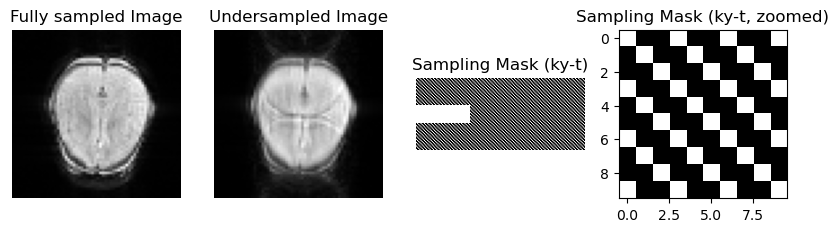

In [10]:

# Visualization
time_point = 0

img_fast = sp.rss(sp.ifft(kspace_full[:,:,:,time_point], axes=[1,2]),0)
slice_image_rss = sp.rss(sp.ifft(kspace_full[:,:,:,time_point], axes=[1,2]),0)
under_image_rss = sp.rss(sp.ifft(kspace_under[:,:,:,time_point], axes=[1,2]),0)
ipat_zoom = ipat[0, 0:10, 0, 0:10 ]


fig, axs = plt.subplots(1,4, figsize=[10,10])
axs[0].imshow(slice_image_rss,cmap='gray')
axs[1].imshow(under_image_rss,cmap='gray')
axs[2].imshow(ipat[0,:,0,:],cmap='gray')
axs[3].imshow(ipat_zoom,cmap='gray')


axs[0].set_title('Fully sampled Image')
axs[1].set_title('Undersampled Image')
axs[2].set_title('Sampling Mask (ky-t)')
axs[3].set_title('Sampling Mask (ky-t, zoomed)')

for jj in range(3):
    axs[jj].axis('off')

In [11]:

(nC, nP, nR, nT) = kspace_full.shape

acs = kspace_full[:, acs_start_y : acs_end_y, :, acs_start_t : acs_end_t]
print('The size of ACS area (coil,PE(y), RO(x), time) is: ', acs.shape)
(_,nP_acs, nR_acs, nT_acs) = acs.shape 

R_eff_y = ((((nP-nP_acs)/R)+nP_acs)/nP)**-1
R_eff_t = ((((nT-nT_acs)/R)+nT_acs)/nT)**-1
print('Acceleration Factor (along y direction): ', str(R), '\n', 'Number ACS Lines (along y direction): ', str(nP_acs), '/', str(nP), '\n', 'Effective Acceleration Factor (along y direction): ', '{:.2f}'.format(R_eff_y))
print('Acceleration Factor (along t direction): ', str(R), '\n', 'Number ACS Lines (along t direction): ', str(nT_acs), '/', str(nT), '\n', 'Effective Acceleration Factor (along t direction): ', '{:.2f}'.format(R_eff_t))

The size of ACS area (coil,PE(y), RO(x), time) is:  (16, 16, 64, 48)
Acceleration Factor (along y direction):  3 
 Number ACS Lines (along y direction):  16 / 64 
 Effective Acceleration Factor (along y direction):  2.00
Acceleration Factor (along t direction):  3 
 Number ACS Lines (along t direction):  48 / 150 
 Effective Acceleration Factor (along t direction):  1.83


In [9]:
mask_kernel_test = np.array([
        [1, 0, 0],
       [0, 1, 0], 
       [0, 0, 1]
       ])
'''mask_kernel_test = np.array([
        [1, 0],
       [0, 1]
       ])'''

# now the shape of mask_kernel_test is (2,2) (along ky-t dimension), make it (256,16,2,3,2) (out_channel, coil, y, x, t)
mask_kernel_input = np.tile(mask_kernel_test, (256,nC,5,1,1))
mask_kernel_input = np.transpose(mask_kernel_input, (0,1,3,2,4))

mask_kernel_hidden = np.tile(mask_kernel_test, (128,256,1,1,1))
mask_kernel_hidden = np.transpose(mask_kernel_hidden, (0,1,3,2,4))

mask_kernel_output = np.tile(mask_kernel_test, (R*(R-1)*nC,128,3,1,1))
mask_kernel_output = np.transpose(mask_kernel_output, (0,1,3,2,4))

print("The shape of mask_kernel_test is (out_channel, coil, y, x, t): ", mask_kernel_test.shape)

layer_design_ktUnder = {'num_hid_layer': 2, # number of hidden layers, in this case, its 2
                    'input_unit': nC,    # number channels in input layer, nC is coil number 
                        1:[256,(3,5,3), mask_kernel_input],   # the first hidden layer has 256 channels, and a kernel size of (2,5,3) in PE- and RO-direction
                        2:[128,(3,1,3)],   # the second hidden layer has 128 channels, and a kernel size of (1,1,1) in PE- and RO-direction
                    'output_unit':[R*(R-1)*nC,(2,3,2)] # the output layer has (R-1)*nC channels, and a kernel size of (1,5,3) in PE- and RO-direction
                    }

raki_reco = rakiReco_ktUnder_CAIPI_3(np.copy(kspace_under), acs, R, layer_design_ktUnder) # get standard RAKI reconstruction

'''if acs_flag: # put ACS back into reconstructed k-space
    raki_reco[:, acs_start:acs_end+1, :, :] = acs'''

The shape of mask_kernel_test is (out_channel, coil, y, x, t):  (3, 3)
Starting Standard RAKI (in k-t undersampling)...
The shape of pseudo kernels is (Nk_p, Nk_r, Nk_t):  6 7 6
The shape of acs is (num_coils, num_p_acs, num_r_acs, num_t_acs):  (16, 30, 64, 48)
The repetitions are (for acs data):  rep_r_acs:  58 rep_t_acs:  13 rep_p_acs:  7


100%|██████████| 500/500 [04:53<00:00,  1.70it/s]


The shape of kspace_zf is (num_coil, num_p_data, num_r_data, num_t_data):  (16, 64, 64, 150)
The shape of pred_mat is:  (18, 58, 47, 96)
The repetitions are (for data blocks):  rep_r:  58 rep_t:  47 rep_p:  18
Finished Standard RAKI...


'if acs_flag: # put ACS back into reconstructed k-space\n    raki_reco[:, acs_start:acs_end+1, :, :] = acs'

In [ ]:
# Build two networks for odd and even time lines, respectively.
# To deal with the odd lines, revert the whole kspace and 

In [ ]:
# Build two networks for odd and even time lines, respectively.

from importlib import reload
import cnn_ktUnder.rakiModels_ktUnder
reload(cnn_ktUnder.rakiModels_ktUnder)
from cnn_ktUnder.rakiModels_ktUnder import rakiReco_ktUnder, irakiReco_ktUnder

'''mask_kernel_test = np.array([
    [[1,0,0], [0,1,0], [0,0,1]],
    [[1,0,0], [0,1,0], [0,0,1]], 
    [[1,0,0], [0,1,0], [0,0,1]]
    ])'''
mask_kernel_test_even = np.array([
        [0, 1],
       [1, 0]
       ])

mask_kernel_test_odd = np.array([
        [1, 0],
        [0, 1]
        ])

# now the shape of mask_kernel_test is (2,2) (along ky-t dimension), make it (256,16,2,3,2) (out_channel, coil, y, x, t)
mask_kernel_test_odd = np.tile(mask_kernel_test_odd, (256,nC,5,1,1))
mask_kernel_test_odd = np.transpose(mask_kernel_test_odd, (0,1,3,2,4))
mask_kernel_test_even = np.tile(mask_kernel_test_even, (256,nC,5,1,1))
mask_kernel_test_even = np.transpose(mask_kernel_test_even, (0,1,3,2,4))

print("The shape of mask_kernel_test is (out_channel, coil, y, x, t): ", mask_kernel_test.shape)

layer_design_ktUnder_odd = {'num_hid_layer': 2, # number of hidden layers, in this case, its 2
                    'input_unit': nC,    # number channels in input layer, nC is coil number 
                    'mask_kernel': mask_kernel_test_odd, # mask_kernel is a 3D array, to specify the shape of the kernel
                        1:[256,(2,5,2)],   # the first hidden layer has 256 channels, and a kernel size of (2,5,3) in PE- and RO-direction
                        2:[128,(1,3,1)],   # the second hidden layer has 128 channels, and a kernel size of (1,1,1) in PE- and RO-direction
                    'output_unit':[(R-1)*nC,(1,5,1)] # the output layer has (R-1)*nC channels, and a kernel size of (1,5,3) in PE- and RO-direction
                    }

layer_design_ktUnder_even = {'num_hid_layer': 2, # number of hidden layers, in this case, its 2
                    'input_unit': nC,    # number channels in input layer, nC is coil number 
                    'mask_kernel': mask_kernel_test_even, # mask_kernel is a 3D array, to specify the shape of the kernel
                        1:[256,(2,5,2)],   # the first hidden layer has 256 channels, and a kernel size of (2,5,3) in PE- and RO-direction
                        2:[128,(1,3,1)],   # the second hidden layer has 128 channels, and a kernel size of (1,1,1) in PE- and RO-direction
                    'output_unit':[(R-1)*nC,(1,5,1)] # the output layer has (R-1)*nC channels, and a kernel size of (1,5,3) in PE- and RO-direction
                    }

raki_reco_odd = rakiReco_ktUnder(np.copy(kspace_under), acs, R, layer_design_ktUnder_odd) # get standard RAKI reconstruction; for odd time lines
raki_reco_even = rakiReco_ktUnder(np.copy(kspace_under), acs, R, layer_design_ktUnder_even) # get standard RAKI reconstruction; for even time lines

# raki_reco is the sum of raki_reco_odd and raki_reco_even
raki_reco = raki_reco_odd + raki_reco_even

'''if acs_flag: # put ACS back into reconstructed k-space
    raki_reco[:, acs_start:acs_end+1, :, :] = acs'''

In [10]:

if acs_flag: # put ACS back into reconstructed k-space
    raki_reco[:, acs_start_y:acs_end_y, :, acs_start_t:acs_end_t] = acs
    print("ACS data is put back into the reconstructed k-space.")
    

ACS data is put back into the reconstructed k-space.


In [11]:
import datetime
import os

# save the train results in a .npy file
train_ver = 'v1'
SAVETRAINDIR = pathlib.Path('/Volumes/YRZHANG/summer_intern/data4yunrui/train_result_temp/RAKI_MRSI_ky_t_CAIPI_3') / ('train_' + train_ver)
SAVEFILE_RECON = 'raki_mrsi_reco_para_' + train_ver + '.npy'
os.makedirs(SAVETRAINDIR, exist_ok=True)
# save the raki_reco result in a .npy file
np.save(SAVETRAINDIR / SAVEFILE_RECON, raki_reco)
print('Saved reconstruction result in npy file: ', SAVETRAINDIR / SAVEFILE_RECON)

# save the parameters in a .txt file
SAVEFILE = 'raki_mrsi_reco_para_ky_t_CAIPI_3' +  '.txt'
with open(SAVETRAINDIR / SAVEFILE, 'a') as f:
    print('Training version: ', train_ver, file=f)
    print('Training time: ', datetime.datetime.now(), file=f)
    print('Undersampling factor: ', R, file=f)
    print('num_hid_layer: ', layer_design_ktUnder['num_hid_layer'], file=f)
    print('mask_kernel: ', layer_design_ktUnder[1][2][5][5][:,0,:], file=f)
    print('coil number:', layer_design_ktUnder['input_unit'], file=f)
    print('1st layer kernel size: ', layer_design_ktUnder[1][0],layer_design_ktUnder[1][1], file=f)
    print('2nd layer kernel size: ', layer_design_ktUnder[2], file=f)
    # print('layer_unit: number of channels', layer_design_raki['input_unit'][0], file=f)
    # print('layer_unit: 1st layer', layer_design_raki['input_unit'][1], file=f)
    print('output layer kernel size: ', layer_design_ktUnder['output_unit'], file=f)
    print(' ', file=f)
    
print('Saved training parameters in: ', SAVETRAINDIR / SAVEFILE)

Saved reconstruction result in npy file:  /Volumes/YRZHANG/summer_intern/data4yunrui/train_result_temp/RAKI_MRSI_ky_t_CAIPI_3/train_v1/raki_mrsi_reco_para_v1.npy
Saved training parameters in:  /Volumes/YRZHANG/summer_intern/data4yunrui/train_result_temp/RAKI_MRSI_ky_t_CAIPI_3/train_v1/raki_mrsi_reco_para_ky_t_CAIPI_3.txt


In [21]:
#TODO: Edit 3D GRAPPA to fit for ky-t undersampling. Maybe write a new function (grappareco_ktUnder). 

from importlib import reload
import grappa.grappaReco_3D
reload(grappa.grappaReco_3D)
from grappa.grappaReco_3D import grappa_3D

grappa_reco = grappa_3D(np.copy(kspace_under), acs, R, {'phase':3, 'read':3, 'time':3}, 0.0001)

if acs_flag:
    grappa_reco[:, acs_start_y:acs_end_y, :, acs_start_t:acs_end_t] = acs
    
'''
from importlib import reload
import grappa.grappaReco_ktUnder
reload(grappa.grappaReco_ktUnder)
from grappa.grappaReco_ktUnder import grappa_ktUnder

grappa_reco = grappa_ktUnder(np.copy(kspace_under), acs, R, {'phase':4, 'read':7, 'time':4}, 0.0001)


if acs_flag:
    grappa_reco[:, acs_start_y:acs_end_y, :, acs_start_t:acs_end_t] = acs'''

debug
Loading Source - & Target Matrix ... 
Done 

Took  0.367  sec 

GRAPPA Weights Calculation...
Done 

Took  3.988 sec 



"\nfrom importlib import reload\nimport grappa.grappaReco_ktUnder\nreload(grappa.grappaReco_ktUnder)\nfrom grappa.grappaReco_ktUnder import grappa_ktUnder\n\ngrappa_reco = grappa_ktUnder(np.copy(kspace_under), acs, R, {'phase':4, 'read':7, 'time':4}, 0.0001)\n\n\nif acs_flag:\n    grappa_reco[:, acs_start_y:acs_end_y, :, acs_start_t:acs_end_t] = acs"

In [14]:
msk = getMask(kspace_full)

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

In [12]:
train_ver = 'v1'
SAVETRAINDIR = pathlib.Path('/Volumes/YRZHANG/summer_intern/data4yunrui/train_result_temp/RAKI_MRSI_ky_t_CAIPI_3') / ('train_' + train_ver)
SAVEFILE_RECON = 'raki_mrsi_reco_para_' + train_ver + '.npy'
raki_reco = np.load(SAVETRAINDIR / SAVEFILE_RECON)

    GRAPPA RAKI UNDERSAMPLED
NMSE 20.6   13.4   242.3
PSNR 38.9   40.7   28.2
SSIM 96.5   98.7   86.9


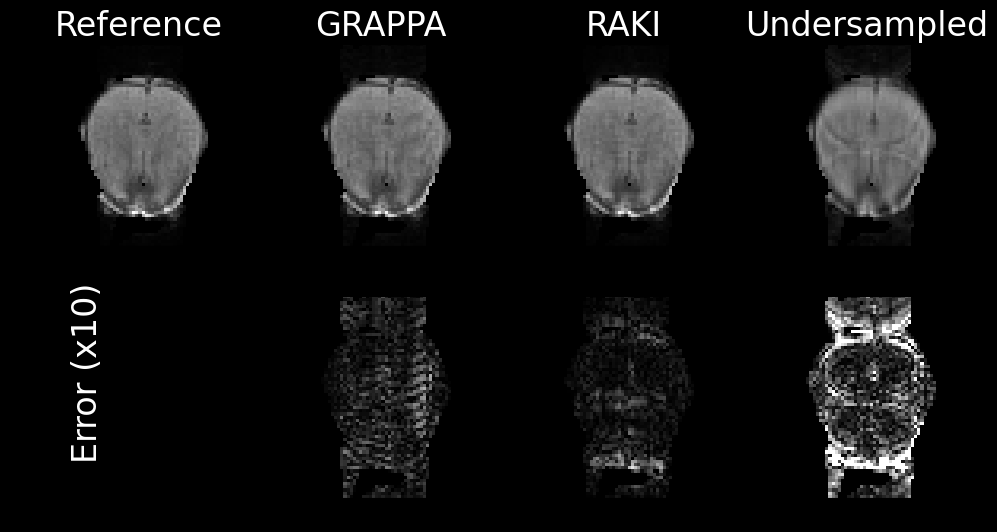

In [25]:
time_point_ind = 3

reference = sp.ifft(kspace_full[:,:,:,time_point_ind], axes=[1,2])
reference = sp.rss(reference, 0)
reference = reference * msk[:,:,time_point_ind]
diff_reference = np.abs(reference - reference)

raki_recoFFT = sp.ifft(raki_reco[:,:,:,time_point_ind], axes=[1, 2])
raki_recoFFT = sp.rss(raki_recoFFT, 0)  
raki_recoFFT = raki_recoFFT * msk[:,:,time_point_ind]
diff_raki = np.abs(reference - raki_recoFFT)
nmse_raki = nmse(reference, raki_recoFFT)
psnr_raki = psnr(reference, raki_recoFFT)
ssim_raki = ssim(reference, raki_recoFFT)

grappa_recoFFT = sp.ifft(grappa_reco[:,:,:,time_point_ind], axes=[1, 2])
grappa_recoFFT = sp.rss(grappa_recoFFT, 0)  
grappa_recoFFT = grappa_recoFFT * msk[:,:,time_point_ind]
diff_grappa = np.abs(reference - grappa_recoFFT)
nmse_grappa = nmse(reference, grappa_recoFFT)
psnr_grappa = psnr(reference, grappa_recoFFT)
ssim_grappa = ssim(reference, grappa_recoFFT)

under_recoFFT = sp.ifft(kspace_under[:,:,:,time_point_ind], axes=[1, 2])
under_recoFFT = sp.rss(under_recoFFT, 0)  
under_recoFFT = under_recoFFT * msk[:,:,time_point_ind]
diff_under = np.abs(reference - under_recoFFT)
nmse_under = nmse(reference, under_recoFFT)
psnr_under = psnr(reference, under_recoFFT)
ssim_under = ssim(reference, under_recoFFT)

max_rss = np.max(np.abs(reference))
alpha = 1.0
diffScaling = 1e1

font = {'fontsize':24, 'color': 'white'}
fig, axs = plt.subplots(2,4,figsize=[12,6], facecolor='k')

axs[0,0].imshow(np.abs(reference), cmap='gray', vmin=0, vmax=max_rss*alpha)
axs[0,1].imshow(np.abs(grappa_recoFFT), cmap='gray', vmin=0, vmax=max_rss*alpha)
axs[0,2].imshow(np.abs(raki_recoFFT), cmap='gray', vmin=0, vmax=max_rss*alpha)
axs[0,3].imshow(np.abs(under_recoFFT), cmap='gray', vmin=0, vmax=max_rss*alpha)

axs[1,0].imshow(np.abs(diff_reference*diffScaling), cmap='gray', vmin=0, vmax=max_rss*alpha)
axs[1,1].imshow(np.abs(diff_grappa*diffScaling), cmap='gray', vmin=0, vmax=max_rss*alpha)
axs[1,2].imshow(np.abs(diff_raki*diffScaling), cmap='gray', vmin=0, vmax=max_rss*alpha)
axs[1,3].imshow(np.abs(diff_under*diffScaling), cmap='gray', vmin=0, vmax=max_rss*alpha)

axs[0,0].set_title('Reference', fontdict=font)
axs[0,1].set_title('GRAPPA', fontdict=font)
axs[0,2].set_title('RAKI', fontdict=font)
axs[0,3].set_title('Undersampled', fontdict=font)
axs[1,0].text(10,50, 'Error (x10)', rotation=90, fontdict=font)

print(3*' ', 'GRAPPA', 'RAKI', 'UNDERSAMPLED')

print('NMSE', str(np.around(1e4*nmse_grappa,1)),' ',str(np.around(1e4*nmse_raki,1)), ' ',str(np.around(1e4*nmse_under,1)))
print('PSNR', str(np.around(psnr_grappa,1)),' ',str(np.around(psnr_raki,1)), ' ',str(np.around(psnr_under,1)))
print('SSIM', str(np.around(1e2*ssim_grappa,1)),' ',str(np.around(1e2*ssim_raki,1)), ' ',str(np.around(1e2*ssim_under,1)))

'''# save the figure
SAVEFIG = 'coil_combination_' + train_ver + '_t={}.png'.format(time_point_ind)
fig.savefig(SAVETRAINDIR / SAVEFIG, dpi=300, bbox_inches='tight', pad_inches=0)'''

# save the results to a txt file, don't rewrite
SAVEMSE = 'coil_combination_MSE_' + train_ver + '.txt'
with open(SAVETRAINDIR / SAVEMSE, 'a') as f:
    f.write('result/RAKI_MRSI_3D_recon/3D_t={}_R={}\n'.format(time_point_ind, R))
    f.write('GRAPPA ' + 'RAKI '+ 'UNDERSAMPLED \n')
    f.write('NMSE: {} {} {}\n'.format(str(np.around(1e4*nmse_grappa,1)), str(np.around(1e4*nmse_raki,1)), str(np.around(1e4*nmse_under,1))))
    f.write('PSNR: {} {} {}\n'.format(str(np.around(psnr_grappa,1)),str(np.around(psnr_raki,1)), str(np.around(psnr_under,1))))
    f.write('SSIM: {} {} {}\n'.format(str(np.around(1e2*ssim_grappa,1)), str(np.around(1e2*ssim_raki,1)), str(np.around(1e2*ssim_under,1))))
    f.write(' \n')

In [16]:
import tqdm

# save multiple time point results: in range nT, every 5 time points
for time_point_ind in tqdm.trange(0, nT, 1):
    reference = sp.ifft(kspace_full[:,:,:,time_point_ind], axes=[1,2])
    reference = sp.rss(reference, 0)
    reference = reference * msk[:,:,time_point_ind]
    diff_reference = np.abs(reference - reference)

    raki_recoFFT = sp.ifft(raki_reco[:,:,:,time_point_ind], axes=[1, 2])
    raki_recoFFT = sp.rss(raki_recoFFT, 0)  
    raki_recoFFT = raki_recoFFT * msk[:,:,time_point_ind]
    diff_raki = np.abs(reference - raki_recoFFT)
    nmse_raki = nmse(reference, raki_recoFFT)
    psnr_raki = psnr(reference, raki_recoFFT)
    ssim_raki = ssim(reference, raki_recoFFT)

    grappa_recoFFT = sp.ifft(grappa_reco[:,:,:,time_point_ind], axes=[1, 2])
    grappa_recoFFT = sp.rss(grappa_recoFFT, 0)  
    grappa_recoFFT = grappa_recoFFT * msk[:,:,time_point_ind]
    diff_grappa = np.abs(reference - grappa_recoFFT)
    nmse_grappa = nmse(reference, grappa_recoFFT)
    psnr_grappa = psnr(reference, grappa_recoFFT)
    ssim_grappa = ssim(reference, grappa_recoFFT)

    under_recoFFT = sp.ifft(kspace_under[:,:,:,time_point_ind], axes=[1, 2])
    under_recoFFT = sp.rss(under_recoFFT, 0)  
    under_recoFFT = under_recoFFT * msk[:,:,time_point_ind]
    diff_under = np.abs(reference - under_recoFFT)
    nmse_under = nmse(reference, under_recoFFT)
    psnr_under = psnr(reference, under_recoFFT)
    ssim_under = ssim(reference, under_recoFFT)

    max_rss = np.max(np.abs(reference))
    alpha = 1.0
    diffScaling = 1e1

    font = {'fontsize':24, 'color': 'white'}
    fig, axs = plt.subplots(2,4,figsize=[12,6], facecolor='k')

    axs[0,0].imshow(np.abs(reference), cmap='gray', vmin=0, vmax=max_rss*alpha)
    axs[0,1].imshow(np.abs(grappa_recoFFT), cmap='gray', vmin=0, vmax=max_rss*alpha)
    axs[0,2].imshow(np.abs(raki_recoFFT), cmap='gray', vmin=0, vmax=max_rss*alpha)
    axs[0,3].imshow(np.abs(under_recoFFT), cmap='gray', vmin=0, vmax=max_rss*alpha)

    axs[1,0].imshow(np.abs(diff_reference*diffScaling), cmap='gray', vmin=0, vmax=max_rss*alpha)
    axs[1,1].imshow(np.abs(diff_grappa*diffScaling), cmap='gray', vmin=0, vmax=max_rss*alpha)
    axs[1,2].imshow(np.abs(diff_raki*diffScaling), cmap='gray', vmin=0, vmax=max_rss*alpha)
    axs[1,3].imshow(np.abs(diff_under*diffScaling), cmap='gray', vmin=0, vmax=max_rss*alpha)

    axs[0,0].set_title('Reference', fontdict=font)
    axs[0,1].set_title('GRAPPA', fontdict=font)
    axs[0,2].set_title('RAKI', fontdict=font)
    axs[0,3].set_title('Undersampled', fontdict=font)
    axs[1,0].text(10,50, 'Error (x10)', rotation=90, fontdict=font)
        
    # save the figure
    os.makedirs(SAVETRAINDIR / 'time_all', exist_ok=True)
    SAVEFIG = 'time_all/3D_t={}_R={}_'.format(time_point_ind,R) + train_ver + '.png'

    # save the results to a txt file, don't rewrite
    SAVEMSE = 'time_all/coil_combination_MSE_' + train_ver + '.txt'
    
    # save the image to the folder
    plt.savefig(SAVETRAINDIR / SAVEFIG, facecolor='k', bbox_inches='tight', pad_inches=0)
    plt.close()
    
    # save the results to a txt file, don't rewrite
    with open(SAVETRAINDIR / SAVEMSE, 'a') as f:
        f.write('result/RAKI_MRSI_3D_recon/3D_t={}_R={}'.format(time_point_ind, R) + train_ver + '\n')
        f.write('GRAPPA ' + 'RAKI '+ 'UNDERSAMPLED \n')
        f.write('NMSE: {} {} {}\n'.format(str(np.around(1e4*nmse_grappa,1)), str(np.around(1e4*nmse_raki,1)), str(np.around(1e4*nmse_under,1))))
        f.write('PSNR: {} {} {}\n'.format(str(np.around(psnr_grappa,1)), str(np.around(psnr_raki,1)), str(np.around(psnr_under,1))))
        f.write('SSIM: {} {} {}\n'.format(str(np.around(1e2*ssim_grappa,1)), str(np.around(1e2*ssim_raki,1)), str(np.around(1e2*ssim_under,1))))
        

100%|██████████| 150/150 [02:36<00:00,  1.04s/it]


"\nSAVESPECDIR = pathlib.Path('/Users/zhangyunrui/Documents/Grad_Application/summer_intern/lam_fan_uiuc/Research/data/result/spectrum/')\nfig.savefig(SAVESPECDIR / 'ktUnder_CAIPI_3_val_x={}_y={}.png'.format(spec_x_idx, spec_y_idx), bbox_inches='tight', pad_inches=0)\nprint('Saved spectrum figure in: ', SAVESPECDIR / 'ktUnder_CAIPI_3_val_x={}_y={}.png'.format(spec_x_idx, spec_y_idx))\n"

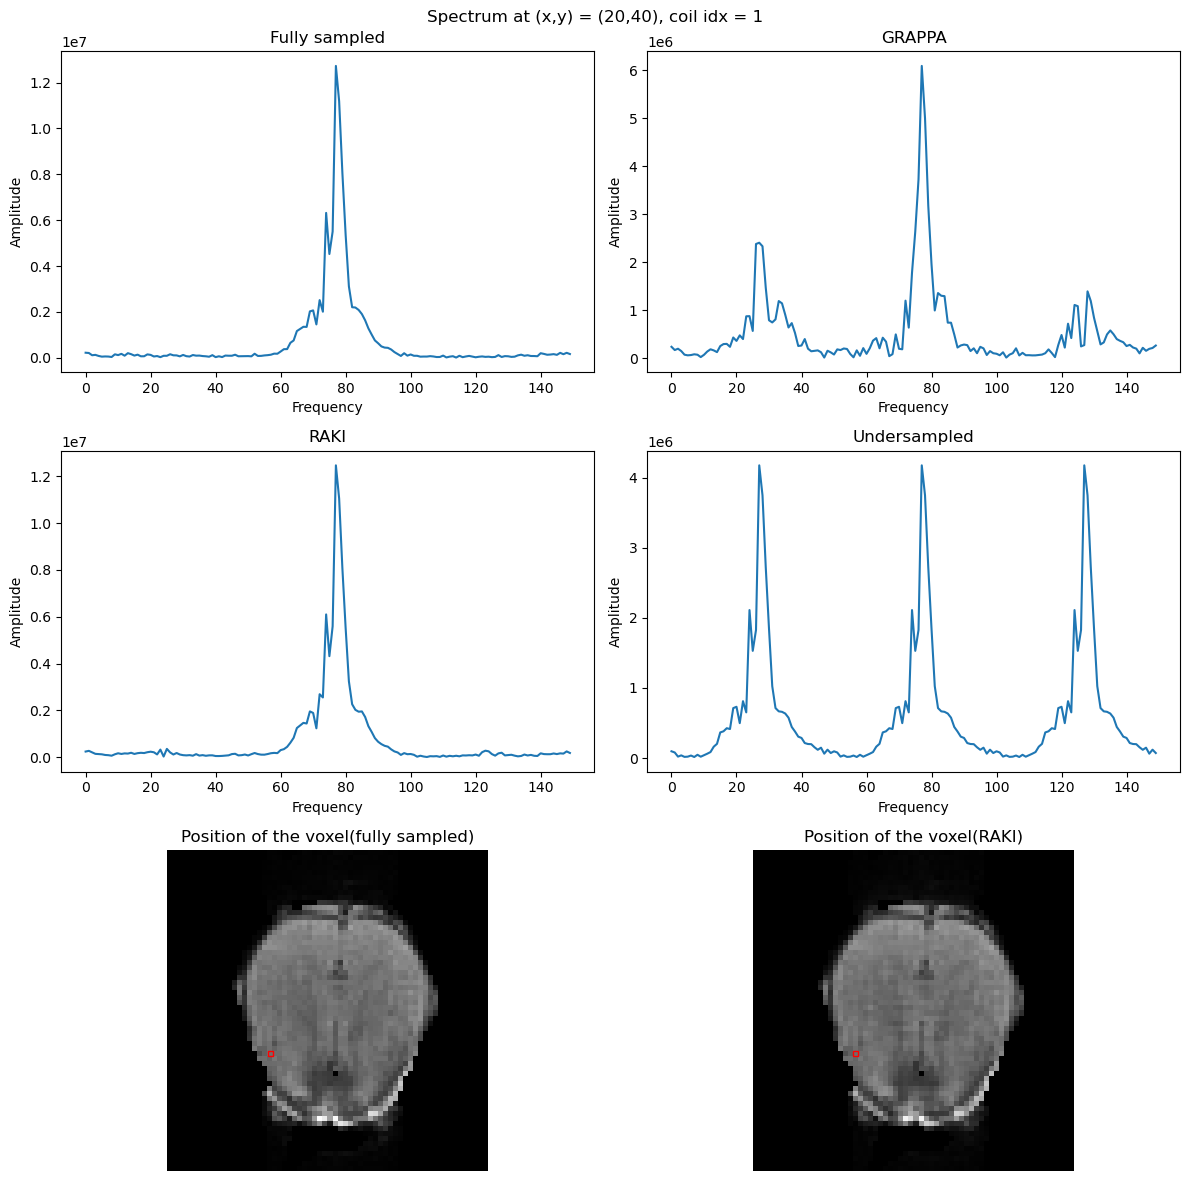

In [31]:
# Visualize the spectrum
import matplotlib.patches as patches

spec_x_idx = 20
spec_y_idx = 40
spec_coil_idx = 0
spec_data_full = kspace_full[spec_coil_idx,spec_y_idx,spec_x_idx,:]
spec_data_grappa = grappa_reco[spec_coil_idx,spec_y_idx,spec_x_idx,:]
spec_data_raki = raki_reco[spec_coil_idx,spec_y_idx,spec_x_idx,:]
spec_data_under = kspace_under[spec_coil_idx,spec_y_idx,spec_x_idx,:]
# do fft along time axis of spec_data to obtain spectrum
spectrum_full = np.fft.fftshift(np.fft.fft(spec_data_full))
spectrum_grappa = np.fft.fftshift(np.fft.fft(spec_data_grappa))
spectrum_raki = np.fft.fftshift(np.fft.fft(spec_data_raki))
spectrum_under = np.fft.fftshift(np.fft.fft(spec_data_under))
# plot the spectrum in subplots
fig, axs = plt.subplots(3,2,figsize=[12,12])
axs[0,0].plot(np.abs(spectrum_full))
axs[0,1].plot(np.abs(spectrum_grappa))
axs[1,0].plot(np.abs(spectrum_raki))
axs[1,1].plot(np.abs(spectrum_under))
axs[2,0].imshow(np.abs(reference), cmap='gray', vmin=0, vmax=max_rss*alpha)
rect = patches.Rectangle((spec_x_idx-0.5,spec_y_idx-0.5),1,1,linewidth=1,edgecolor='r',facecolor='none')
axs[2,0].add_patch(rect)
axs[2,1].imshow(np.abs(raki_recoFFT), cmap='gray', vmin=0, vmax=max_rss*alpha)
rect = patches.Rectangle((spec_x_idx-0.5,spec_y_idx-0.5),1,1,linewidth=1,edgecolor='r',facecolor='none')
axs[2,1].add_patch(rect)

axs[0,0].set_title('Fully sampled')
axs[0,1].set_title('GRAPPA')
axs[1,0].set_title('RAKI')
axs[1,1].set_title('Undersampled')
axs[2,0].set_title('Position of the voxel(fully sampled)')
axs[2,1].set_title('Position of the voxel(RAKI)')

for jj in range(2):
    for ii in range(2):
        axs[ii, jj].set_xlabel('Frequency')
        axs[ii, jj].set_ylabel('Amplitude')
    axs[2,jj].set_xlabel('x')
    axs[2,jj].set_ylabel('y')
    axs[2,jj].axis('off')


fig.suptitle('Spectrum at (x,y) = ({},{}), coil idx = {}'.format(spec_x_idx, spec_y_idx, spec_coil_idx+1))
fig.tight_layout()
# fig.subplots_adjust(top=0.85)

'''
SAVESPECDIR = pathlib.Path('/Users/zhangyunrui/Documents/Grad_Application/summer_intern/lam_fan_uiuc/Research/data/result/spectrum/')
fig.savefig(SAVESPECDIR / 'ktUnder_CAIPI_3_val_x={}_y={}.png'.format(spec_x_idx, spec_y_idx), bbox_inches='tight', pad_inches=0)
print('Saved spectrum figure in: ', SAVESPECDIR / 'ktUnder_CAIPI_3_val_x={}_y={}.png'.format(spec_x_idx, spec_y_idx))
'''